In [43]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, cross_val_score

#feature selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, VarianceThreshold
from skfeature.function.similarity_based import fisher_score

from imblearn.combine import SMOTEENN

from sklearn.metrics import accuracy_score, precision_recall_curve,classification_report,roc_curve
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
df=pd.read_csv("bank-full.csv", sep=";")
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
#checking ratio of yes and no values so we can proceed accordingly
100*df['y'].value_counts()/len(df['y'])

no     88.30152
yes    11.69848
Name: y, dtype: float64

In [6]:
#removing reduandant columns since they give the same info as pdays
df.drop(["day","month"], axis=1 , inplace = True)

In [7]:
#changing values to nan where unknown
for i in df.columns:
    df[i] = np.where(df[i] == "unknown", np.nan, df[i])
df.isna().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

In [8]:
#dropping poutcome since a lot of values are missing
df.drop("poutcome", inplace = True, axis = 1)

In [9]:
#contact doesnt affect target variable
df.drop("contact", inplace = True, axis = 1)

In [10]:
df["job"].fillna(method = "ffill",inplace=True)
df["education"].fillna(method = "ffill",inplace= True)

In [11]:
df


,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,y
0,58.0,management,married,tertiary,no,2143.0,yes,no,261.0,1.0,-1.0,0.0,no
1,44.0,technician,single,secondary,no,29.0,yes,no,151.0,1.0,-1.0,0.0,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,76.0,1.0,-1.0,0.0,no
3,47.0,blue-collar,married,secondary,no,1506.0,yes,no,92.0,1.0,-1.0,0.0,no
4,33.0,blue-collar,single,secondary,no,1.0,no,no,198.0,1.0,-1.0,0.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,technician,married,tertiary,no,825.0,no,no,977.0,3.0,-1.0,0.0,yes
45207,71.0,retired,divorced,primary,no,1729.0,no,no,456.0,2.0,-1.0,0.0,yes
45208,72.0,retired,married,secondary,no,5715.0,no,no,1127.0,5.0,184.0,3.0,yes
45209,57.0,blue-collar,married,secondary,no,668.0,no,no,508.0,4.0,-1.0,0.0,no


In [12]:
#convert yes/no to 1/0
yes_no_list=['default','housing','loan','y']
for i in yes_no_list:
    df[i]=np.where(df[i]=='yes',1,0)


In [13]:
#one hot encode jobs column
one = OneHotEncoder()
df[list(df["job"].unique())] = one.fit_transform(df[["job"]]).A
df.drop("job",axis = 1, inplace = True)

In [14]:
df[list(df["marital"].unique())] = one.fit_transform(df[["marital"]]).A
df.drop("marital",axis = 1, inplace = True)

In [15]:
df["education"].replace({'primary':0, 'secondary':1, 'tertiary':2},inplace = True)

In [16]:
df

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,retired,admin.,services,self-employed,unemployed,housemaid,student,married,single,divorced
0,58.0,2,0,2143.0,1,0,261.0,1.0,-1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,44.0,1,0,29.0,1,0,151.0,1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,33.0,1,0,2.0,1,1,76.0,1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,47.0,1,0,1506.0,1,0,92.0,1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,33.0,1,0,1.0,0,0,198.0,1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,2,0,825.0,0,0,977.0,3.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45207,71.0,0,0,1729.0,0,0,456.0,2.0,-1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45208,72.0,1,0,5715.0,0,0,1127.0,5.0,184.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45209,57.0,1,0,668.0,0,0,508.0,4.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,retired,admin.,services,self-employed,unemployed,housemaid,student,married,single,divorced
age,1.000000,-0.158458,-0.017879,0.097783,-0.185513,-0.015655,-0.004648,0.004760,-0.023758,0.001288,...,-0.021421,0.447610,-0.006918,-0.064628,-0.194673,-0.067143,0.001088,0.164674,0.286257,-0.427817
education,-0.158458,1.000000,-0.011546,0.068808,-0.080129,-0.027682,0.001960,0.002771,0.005630,0.025969,...,0.501686,-0.111445,0.084710,-0.084598,0.018727,0.064180,-0.030691,-0.003813,-0.141395,0.156370
default,-0.017879,-0.011546,1.000000,-0.066745,-0.006025,0.077234,-0.010021,0.016822,-0.029979,-0.018329,...,-0.002660,-0.011540,0.003932,-0.000181,-0.016360,-0.003442,0.006308,0.017777,-0.014460,0.003115
balance,0.097783,0.068808,-0.066745,1.000000,-0.068768,-0.084350,0.021560,-0.014578,0.003435,0.016674,...,0.068221,0.047433,0.017666,-0.037809,0.000942,-0.015703,0.009329,-0.021732,0.025708,-0.012537
housing,-0.185513,-0.080129,-0.006025,-0.068768,1.000000,0.041323,0.005075,-0.023599,0.124178,0.037076,...,-0.066265,-0.158402,-0.028580,0.068664,-0.085859,-0.015289,-0.049265,0.001778,0.017681,-0.020475
loan,-0.015655,-0.027682,0.077234,-0.084350,0.041323,1.000000,-0.012412,0.009980,-0.022754,-0.011043,...,-0.040169,-0.015763,-0.008383,0.034890,-0.058912,0.014086,-0.036315,0.016377,0.036906,-0.051716
duration,-0.004648,0.001960,-0.010021,0.021560,0.005075,-0.012412,1.000000,-0.084570,-0.001565,0.001203,...,-0.008884,0.025306,0.007293,0.001257,-0.004526,-0.009265,0.020440,0.006100,-0.022683,0.020328
campaign,0.004760,0.002771,0.016822,-0.014578,-0.023599,0.009980,-0.084570,1.000000,-0.088628,-0.032855,...,0.017218,-0.030016,0.006485,-0.004618,-0.022008,0.021198,-0.018696,-0.015484,0.031371,-0.023120
pdays,-0.023758,0.005630,-0.029979,0.003435,0.124178,-0.022754,-0.001565,-0.088628,1.000000,0.454820,...,-0.008100,-0.006757,-0.010590,0.005021,0.026009,-0.013954,-0.010561,0.002897,-0.027600,0.027943
previous,0.001288,0.025969,-0.018329,0.016674,0.037076,-0.011043,0.001203,-0.032855,0.454820,1.000000,...,0.019534,0.005407,-0.002354,-0.011293,0.023664,-0.001507,-0.008287,-0.004534,-0.012691,0.017006


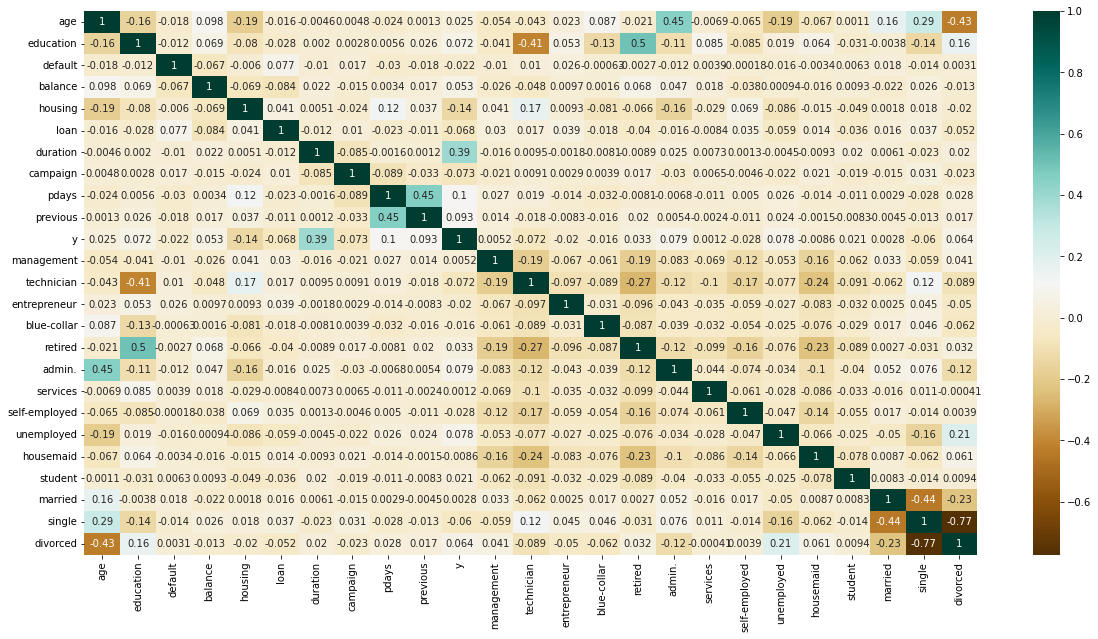

In [17]:
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [19]:
# checking variance threshold 
var_th = VarianceThreshold(threshold = 0.0)
var_th.fit_transform(_)
s = pd.Series(var_th.get_support(),index = _.columns)
s

age         True
default     True
balance     True
housing     True
loan        True
duration    True
campaign    True
pdays       True
previous    True
dtype: bool

In [20]:
# Chi2 test (between categorical features)
_temp = df[['education', 'default', 'housing', 'loan',
        'campaign', 'previous']]
chi, p_val = chi2(_temp,df["y"])
s = pd.DataFrame({"Chi2":np.around(chi,2), "P_val": np.around(p_val,2)}, index = _temp.columns)
s

,Chi2,P_val
education,90.33,0.0
default,22.31,0.0
housing,388.95,0.0
loan,176.52,0.0
campaign,840.58,0.0
previous,3593.22,0.0


In [21]:
# taking annova test (continuous vs categorical features)
_temp = df[['age', 'balance', 'duration', 'pdays']]
f_val,p_val = f_classif(_temp,df["y"])
pd.DataFrame({"F_Val": np.around(f_val,2), "P_val": np.around(p_val,2)},index = _temp.columns)

,F_Val,P_val
age,28.63,0.0
balance,126.57,0.0
duration,8333.76,0.0
pdays,490.70,0.0


In [22]:
X = df.drop("y",axis = 1)
Y = df["y"]

In [23]:
df.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,retired,admin.,services,self-employed,unemployed,housemaid,student,married,single,divorced
0,58.0,2,0,2143.0,1,0,261.0,1.0,-1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,44.0,1,0,29.0,1,0,151.0,1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,33.0,1,0,2.0,1,1,76.0,1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,47.0,1,0,1506.0,1,0,92.0,1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,33.0,1,0,1.0,0,0,198.0,1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
#removing imbalance
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X,Y)

In [25]:
print(f"First we have the value counts:\n{Y.value_counts()}\n\nAfter OverSampling now we have value counts:\n{y_resampled.value_counts()}")

First we have the value counts:
0    39922
1     5289
Name: y, dtype: int64

After OverSampling now we have value counts:
1    32729
0    27440
Name: y, dtype: int64


In [26]:
x_train, x_test, y_train, y_test=train_test_split(X_resampled, y_resampled,test_size=0.20, random_state=42)

In [27]:
#scaling only train data to skip data leakage
std = StandardScaler()
arr = std.fit_transform(x_train)
std_x = pd.DataFrame(arr, columns = x_train.columns)
std_x.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,retired,admin.,services,self-employed,unemployed,housemaid,student,married,single,divorced
0,0.154152,-0.113924,-0.111588,-0.429952,-0.774850,-0.319282,-0.853629,-0.207532,-0.505800,-0.358521,...,-0.591039,-0.299772,-0.203566,-0.321342,-0.206787,2.447742,-0.204891,-0.393606,0.940839,-0.731376
1,-1.103110,-0.113924,-0.111588,0.588993,-0.774850,-0.319282,-0.044805,-0.348942,1.152647,0.463593,...,-0.065952,-0.299772,-0.203566,-0.321342,-0.206787,-0.478245,-0.204891,-0.393606,-1.240350,1.597124
2,0.154152,-0.113924,-0.111588,-0.378363,1.290573,-0.319282,-0.848155,0.153541,-0.505800,-0.358521,...,-0.591039,-0.299772,-0.203566,-0.321342,-0.206787,2.447742,-0.204891,-0.393606,0.940839,-0.731376
3,-0.576318,-0.113924,-0.111588,-0.364071,1.290573,-0.319282,-0.870050,-0.207532,-0.505800,-0.358521,...,-0.591039,-0.299772,-0.203566,-0.321342,-0.206787,2.447742,-0.204891,-0.393606,0.940839,-0.731376
4,1.026502,-1.694248,-0.111588,0.081124,-0.774850,-0.319282,0.711155,-0.109267,-0.505800,-0.358521,...,-0.591039,1.272543,-0.203566,-0.321342,-0.206787,-0.478245,-0.204891,-0.393606,0.940839,-0.731376


In [28]:
#scaling test data using train data scaler
arr1 = std.transform(x_test)
std_x_te = pd.DataFrame(arr1, columns = x_test.columns)
std_x_te.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,retired,admin.,services,self-employed,unemployed,housemaid,student,married,single,divorced
0,-1.262066,-0.113924,-0.111588,1.337529,-0.774850,-0.319282,-0.253297,-0.568605,0.33211,1.272286,...,-0.506488,-0.299772,-0.203566,-0.321342,5.768948,-0.478245,-0.204891,-0.393606,-1.169127,1.521091
1,0.245461,-1.694248,-0.111588,-0.653387,1.290573,-0.319282,-0.451304,-0.207532,-0.50580,-0.358521,...,-0.591039,-0.299772,-0.203566,-0.321342,-0.206787,-0.478245,-0.204891,-0.393606,0.940839,-0.731376
2,-1.030349,-1.694248,-0.111588,-0.649891,-0.774850,-0.319282,0.123648,0.933105,-0.50580,-0.358521,...,-0.591039,-0.299772,-0.203566,-0.321342,-0.206787,-0.478245,-0.204891,0.171048,0.573972,-0.731376
3,0.884623,-1.694248,-0.111588,-0.402414,-0.774850,3.132023,-1.031528,1.236759,-0.50580,-0.358521,...,-0.591039,-0.299772,-0.203566,-0.321342,-0.206787,2.447742,-0.204891,2.963524,-1.240350,-0.731376
4,2.345563,-0.113924,-0.111588,5.193226,-0.774850,-0.319282,-0.443093,-0.207532,-0.50580,-0.358521,...,-0.591039,-0.299772,-0.203566,-0.321342,-0.206787,-0.478245,-0.204891,-0.393606,0.940839,-0.731376


In [61]:
def model(classifier):
    
    classifier.fit(std_x,y_train)
    prediciton_train=classifier.predict(std_x)
    prediction_test = classifier.predict(std_x_te)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 42)
    print("Train Accuracy : ",'{0:.2%}'.format(accuracy_score(y_train,prediciton_train)))
    print("Test Accuracy : ",'{0:.2%}'.format(accuracy_score(y_test,prediction_test)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,std_x,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction_test)))
    #plot_roc_curve(classifier, x_test,y_test)
   # plt.title('ROC_AUC_Plot')
   # plt.show()

def model_evaluation(classifier):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(std_x_te))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #sns.heatmap(cm,annot = labels, fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(std_x_te)))

In [34]:
lr = LogisticRegression() 
model(lr)
model_evaluation(lr)

Train Accuracy :  89.78%
Test Accuracy :  90.02%
Cross Validation Score :  96.00%
ROC_AUC Score :  89.88%
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      5428
           1       0.91      0.91      0.91      6606

    accuracy                           0.90     12034
   macro avg       0.90      0.90      0.90     12034
weighted avg       0.90      0.90      0.90     12034



In [35]:
knn=KNeighborsClassifier()
model(knn)
model_evaluation(knn)

Train Accuracy :  95.24%
Test Accuracy :  92.80%
Cross Validation Score :  97.18%
ROC_AUC Score :  92.85%
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      5428
           1       0.94      0.92      0.93      6606

    accuracy                           0.93     12034
   macro avg       0.93      0.93      0.93     12034
weighted avg       0.93      0.93      0.93     12034



In [38]:
svm=SVC()
model(svm)
model_evaluation(svm)

Train Accuracy :  94.72%
Test Accuracy :  94.21%
ROC_AUC Score :  94.24%
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5428
           1       0.96      0.94      0.95      6606

    accuracy                           0.94     12034
   macro avg       0.94      0.94      0.94     12034
weighted avg       0.94      0.94      0.94     12034



In [39]:
rf= RandomForestClassifier()
model(rf)
model_evaluation(rf)

Train Accuracy :  100.00%
Test Accuracy :  96.53%
ROC_AUC Score :  96.53%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5428
           1       0.97      0.97      0.97      6606

    accuracy                           0.97     12034
   macro avg       0.96      0.97      0.97     12034
weighted avg       0.97      0.97      0.97     12034



In [40]:
abc= AdaBoostClassifier()
model(abc)
model_evaluation(abc)

Train Accuracy :  95.29%
Test Accuracy :  95.44%
ROC_AUC Score :  95.45%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5428
           1       0.96      0.95      0.96      6606

    accuracy                           0.95     12034
   macro avg       0.95      0.95      0.95     12034
weighted avg       0.95      0.95      0.95     12034



In [41]:
xgb= XGBClassifier()
model(xgb)
model_evaluation(xgb)

Train Accuracy :  98.27%
Test Accuracy :  96.72%
ROC_AUC Score :  96.75%
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5428
           1       0.98      0.96      0.97      6606

    accuracy                           0.97     12034
   macro avg       0.97      0.97      0.97     12034
weighted avg       0.97      0.97      0.97     12034



In [44]:
lightgbm = LGBMClassifier()
model(lightgbm)
model_evaluation(lightgbm)

Train Accuracy :  97.11%
Test Accuracy :  96.54%
ROC_AUC Score :  96.57%
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5428
           1       0.97      0.96      0.97      6606

    accuracy                           0.97     12034
   macro avg       0.96      0.97      0.97     12034
weighted avg       0.97      0.97      0.97     12034



In [45]:
et= ExtraTreesClassifier()
model(et)
model_evaluation(et)

Train Accuracy :  100.00%
Test Accuracy :  96.39%
ROC_AUC Score :  96.40%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5428
           1       0.97      0.96      0.97      6606

    accuracy                           0.96     12034
   macro avg       0.96      0.96      0.96     12034
weighted avg       0.96      0.96      0.96     12034



In [47]:
mlp=MLPClassifier(max_iter= 1000)
model(mlp)
model_evaluation(mlp)

Train Accuracy :  96.14%
Test Accuracy :  95.30%
ROC_AUC Score :  95.34%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5428
           1       0.96      0.95      0.96      6606

    accuracy                           0.95     12034
   macro avg       0.95      0.95      0.95     12034
weighted avg       0.95      0.95      0.95     12034



In [ ]:
lst = [("LogisticRegression",LogisticRegression()),
       ("KNN Classifier", KNeighborsClassifier()),
       ("RandomForest",RandomForestClassifier()),
      ("AdaBoost",AdaBoostClassifier()),
      ("XGBoost",XGBClassifier())]
for name,model in lst:
    model.fit(std_x,y_train)
    y1 = model.predict(std_x)
    accuracy = accuracy_score(y_train,y1)
    y2 = model.predict(std_x_te)
    acc_te = accuracy_score(y_test,y2)
    print(f"For {name}::\nThe Training Accuracy is: {accuracy}\nThe Testing Accuracy is: {acc_te}")
    print("--"*40)

In [55]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, shuffle= True, random_state=42)
scores = cross_val_score(ExtraTreesClassifier(),std_x,y_train, cv=kfold, scoring = 'roc_auc')
print("Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))


Accuracy: 99.29% (0.11%)


In [54]:
# Hyperparameter Tuning for XGBoost classifier
from scipy.stats import uniform, randint
estimator = XGBClassifier()
params = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(2, 10),
    "learning_rate": uniform(0.01, 0.3),
    "colsample_bytree": uniform(0.3, 0.7),
    "subsample": uniform(0.3, 0.7),
    "gamma": uniform(0, 0.5),
    "reg_lambda": uniform(0, 2),
}
rscv = RandomizedSearchCV(estimator, params, cv = 5, random_state= 42)
rscv.fit(std_x,y_train)
rscv.best_params_


{'colsample_bytree': 0.3406585285177396,
 'gamma': 0.4330880728874676,
 'learning_rate': 0.19033450352296263,
 'max_depth': 9,
 'n_estimators': 180,
 'reg_lambda': 0.041168988591604894,
 'subsample': 0.978936896513396}

In [62]:
#Final Prediction
xgb_rscv= XGBClassifier(colsample_bytree= 0.34, gamma= 0.43, learning_rate= 0.19, max_depth= 9, n_estimators= 180, reg_lambda= 0.04, subsample= 0.98)
model(xgb_rscv)
model_evaluation(xgb_rscv)

Train Accuracy :  99.31%
Test Accuracy :  96.85%
Cross Validation Score :  99.51%
ROC_AUC Score :  96.89%
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5428
           1       0.98      0.96      0.97      6606

    accuracy                           0.97     12034
   macro avg       0.97      0.97      0.97     12034
weighted avg       0.97      0.97      0.97     12034

